In [1]:
!pip3 install sentencepiece
!pip3 install tf-sentencepiece
!pip3 install matplotlib
#!pip3 install tqdm
#!pip install tensorflow==1.13.1

     |████████████████████████████████| 1.0MB 4.8MB/s 
     |████████████████████████████████| 2.4MB 5.0MB/s 


In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir + "data/")
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['Kaggle Amazon Fine Food.ipynb', 'Organic Dataset.ipynb', 'cache', 'Amazon Reviews.ipynb', 'Dataset_Amazon_Multilingual.ipynb', 'Amazon Multilingual.ipynb', '__pycache__', 'amazon_multilingual.py']


In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import numpy as np
import tf_sentencepiece

import amazon_multilingual
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import glob, time
from tqdm import tqdm_notebook as tqdm

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

W0529 16:35:49.731636 139891058571136 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
Version:  1.13.1
Eager mode:  False
Hub version:  0.4.0
GPU is available


## create graph

In [0]:
class Model:
    def __init__(self, data_X, data_Y, architecture, xling=None):
        self.n_class = 35
        self.architecture = architecture
        if xling is None:
          print("Downloading xling...")
          self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling-many/1", trainable=False) 
        else:
          self.xling = xling
        self.create_architecture(data_X, data_Y)
        
        
    def create_architecture(self, data_X, data_Y):
        #y_hot = tf.one_hot(data_Y, depth=self.n_class)
        self.logits = self.forward(data_X)
        
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.logits))
        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)

        self.predictions = tf.argmax(self.logits,1)
        #self.acc, self.acc_op = tf.metrics.accuracy(labels=data_Y, predictions=self.predictions)
        
        #a = tf.cast(self.predictions, tf.float64)
        self.accuracy = tf.reduce_mean( tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32) )
        
    def forward(self, X):
        output = self.xling(X)
        
        for x in self.architecture:
          if x == "bn":
            output = tf.layers.batch_normalization(output, training=True)
          elif x == "relu":
            output = tf.nn.relu(output)
          elif x == "dropout":
            output = tf.layers.dropout(output)
          else:
            output = tf.layers.dense(output, x)
            
        output = tf.layers.dense(output, self.n_class)
        
        return output

# train

In [0]:
def trainModel(model, epochs):

  init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
  sess = tf.Session()
  sess.run(init_op)

  loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
  loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = [], [], [], []

  for epoch in tqdm(range(epochs)):
    #print('\nEpoch: {}'.format(epoch + 1))
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0  
    counter = 0

    sess.run(train_iterator, feed_dict=feed_dict_train)

    try:
      #with tqdm(total = length_train) as pbar:
        while True:
          _, a, l = sess.run([model.train_op, model.accuracy, model.loss])
          #print(a,l)
          train_loss += l
          train_accuracy += a
          loss_hist.append(l)
          acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(batchSize)
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    loss_hist_epoch.append(train_loss / counter)
    acc_hist_epoch.append(train_accuracy / counter)
    #print('\nEpoch: {}'.format(epoch + 1))
    


    # Validation
    counter = 0
    sess.run(val_iterator, feed_dict=feed_dict_val) 
    try:
      #with tqdm(total = length_val) as pbar:
        while True:
          a, l = sess.run([model.accuracy, model.loss])
          val_loss += l
          val_accuracy += a
          val_loss_hist.append(l)
          val_acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(batchSize)
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    val_loss_hist_epoch.append(val_loss / counter)
    val_acc_hist_epoch.append(val_accuracy / counter)
    print('\tEpoch {}: Train loss: {:.4f}, accuracy: {:.4f}, Val loss: {:.4f}, accuracy: {:.4f}'.format(epoch + 1, loss_hist_epoch[-1], acc_hist_epoch[-1], val_loss_hist_epoch[-1], val_acc_hist_epoch[-1]))
    
    
  
  sess.close()
  return loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch , val_acc_hist_epoch

In [0]:
import matplotlib.pyplot as plt
import datetime, os

def plotResults(x1, label1, x2, label2, title, path, architecture):
  plt.plot(x1, label=label1)
  plt.plot(x2, label=label2)
  plt.legend()
  plt.title(title)
  #plt.ylim(0,1)
  figpath = path + title + ".png"
  #figpath = figpath.replace()
  #print(figpath)
  plt.savefig(figpath)
  plt.show()
  
  np.save(path + str(architecture) + label1 + ".npy", x1)
  np.save(path + str(architecture) + label2 + ".npy", x2)

saving to: /content/gdrive/My Drive/nlp/blobs/2019-05-29_16-35-52/
Using default buffer size: 8000
dataset is not shuffled and prefetched
Instructions for updating:
Colocations handled automatically by placer.


W0529 16:36:04.871837 139891058571136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:358: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0529 16:36:25.904627 139891058571136 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.dense instead.


W0529 16:36:26.485937 139891058571136 deprecation.py:323] From <ipython-input-4-0cd5c1776a57>:39: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


[False]


	Epoch 1: Train loss: 3.2076, accuracy: 0.4180, Val loss: 3.0164, accuracy: 0.4695
	Epoch 2: Train loss: 2.5800, accuracy: 0.6170, Val loss: 2.5633, accuracy: 0.5834
	Epoch 3: Train loss: 2.1308, accuracy: 0.6469, Val loss: 2.2178, accuracy: 0.6162
	Epoch 4: Train loss: 1.8226, accuracy: 0.6551, Val loss: 1.9558, accuracy: 0.6314
	Epoch 5: Train loss: 1.6103, accuracy: 0.6608, Val loss: 1.7580, accuracy: 0.6416
	Epoch 6: Train loss: 1.4601, accuracy: 0.6652, Val loss: 1.6081, accuracy: 0.6492
	Epoch 7: Train loss: 1.3523, accuracy: 0.6691, Val loss: 1.4928, accuracy: 0.6564
	Epoch 8: Train loss: 1.2719, accuracy: 0.6727, Val loss: 1.4025, accuracy: 0.6624
	Epoch 9: Train loss: 1.2118, accuracy: 0.6758, Val loss: 1.3312, accuracy: 0.6680
	Epoch 10: Train loss: 1.1632, accuracy: 0.6786, Val loss: 1.2734, accuracy: 0.6730
	Epoch 11: Train loss: 1.1238, accuracy: 0.6810, Val loss: 1.2260, accuracy: 0.6772
	Epoch 12: Train loss: 1.0930, accuracy: 0.6822, Val loss: 1.1866, accuracy: 0.6802
	

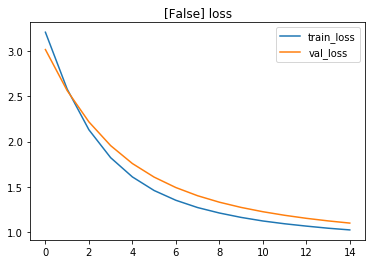

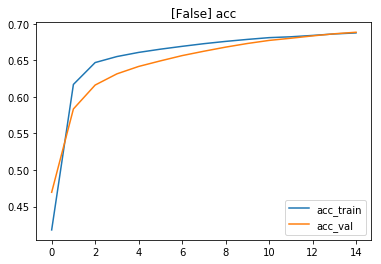

In [7]:
params = {}
params["trainData"] = "UK"
params["testData"] = "DE"
params["epochs"] = 15
params["batchSize"] = 2000
params["trainexamples"] = 1000 * 100
#params["trainEmbeddings"] = False

path = '/content/gdrive/My Drive/nlp/blobs/' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
os.mkdir(path)
print("saving to:", path)


#done [False,50], [False,150], [False,150,50],  
architectures = [ [False] ]

f = open(path + "info.txt", "w")
f.write(str(params)+"\n architectures: "+str(architectures))
f.close()

for a in architectures:
  dataset_train, feed_dict_train, length_train = amazon_multilingual.getData(params["trainData"], shuffle=True, batchsize=params["batchSize"])
  dataset_val, feed_dict_val, length_val = amazon_multilingual.getData(params["testData"], shuffle=False, batchsize=params["batchSize"])
  
  dataset_train = dataset_train.take(int(params["trainexamples"]/params["batchSize"]))
  dataset_val = dataset_val.take(int(params["trainexamples"]/params["batchSize"]))
  
  iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
  train_iterator = iterator.make_initializer(dataset_train)
  val_iterator = iterator.make_initializer(dataset_val)
  text_input, label = iterator.get_next()
  
  xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=a[0])
  model = Model(text_input, label, a[1:], xling)
  print(str(a))
  %time loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = trainModel(model, params["epochs"])
  print("\t", loss_hist_epoch, acc_hist_epoch, "\n\t", val_loss_hist_epoch, val_acc_hist_epoch)
  plotResults(loss_hist_epoch, "train_loss", val_loss_hist_epoch, "val_loss", str(a)+" loss", path, a)
  plotResults(acc_hist_epoch, "acc_train", val_acc_hist_epoch, "acc_val", str(a)+ " acc", path, a)
  
  tf.reset_default_graph()
  del model, xling, dataset_train, feed_dict_train, length_train, dataset_val, feed_dict_val, length_val, iterator,train_iterator,val_iterator,text_input, label
  tf.reset_default_graph()

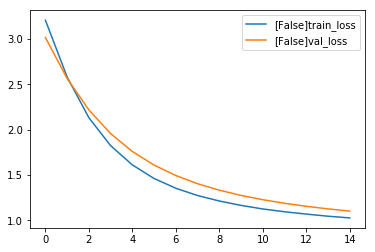

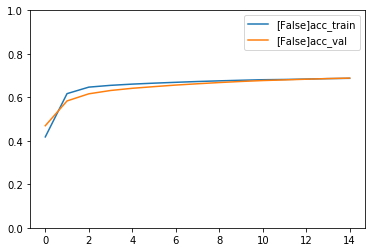

In [8]:
for f in glob.glob(path+"*loss.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.savefig(path+"allloss.png")
plt.show()

for f in glob.glob(path+"*acc*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allacc.png")
plt.show()